In [1]:
# 导入库函数
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [2]:
# LPP算法函数

# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(n, distances): 
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 以将距离从小到大排序后的第k个距离作为每个数据点的半径
def compute_k_maximun_radius(n, distances, k):
    radius = np.zeros(n)
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    for i in range(n):
        # 选取第k个距离作为半径
        radius[i] = sorted_distances[i, k]
    return radius


def knn_graph(Data, method, k):
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 计算k最近邻接矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_k_maximun_radius(n, distances, k)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 获取epsilon邻域内的样本索引
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances


# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, k, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    # 计算相似度矩阵
    similarity_matrix = np.exp(-distances ** 2 / t)
    # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    # 设置权重
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix               

In [3]:
# MLDA算法函数

# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    num_features = train_data.shape[1]  # 每个样本的特征维度
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
    return means  # 返回每个类别的均值矩阵
"""
# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵
"""

'\n# 计算所有类别的整体均值矩阵\ndef compute_overall_mean_matrix(classes_means):\n    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值\n    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）\n\n# 计算中心类别矩阵\ndef compute_center_class_matrix(train_data, train_labels, classes_means):\n    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵\n    \n    for i in range(train_data.shape[0]):  # 遍历训练数据\n        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引\n        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵\n        \n    return Z  # 返回中心类别矩阵\n\n# 计算类间散布矩阵\ndef compute_between_class_scatter_matrix(classes_means, overall_mean):\n    n = 5  # 训练集与测试集的比例\n    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵\n    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵\n        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵\n    return Sb  # 返回类间散布矩阵\n\n# 计算类内散布矩阵\ndef compute_class_scatter_matrix

In [4]:
def ShowEigenface(eigenfaces, faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    plt.show()

In [5]:
def LPP(train_data, train_labels, method, d, k, t):
    Data = train_data.T
    n = len(train_labels)
    Weight_matrices = np.zeros((n, n)) # 存储每个类别的权重矩阵
    Degree_matrices = np.zeros((n, n)) # 存储每个类别的度矩阵
    for class_label in np.unique(train_labels):
        class_indices = np.where(train_labels == class_label)[0]  # 获取当前类别的样本索引
        class_train_data = Data[:, class_indices]  # 获取当前类别的样本数据
        Weight_matrix = construct_weight_matrix(class_train_data, method, k, t)  # 计算当前类别的权重矩阵
        Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))  # 计算当前类别的度矩阵
        # 将Degree_matrix和Weight_matrix计算矩阵的迹并添加到对角线
        class_idx = class_label - 1
        Weight_matrices[class_idx, class_idx] = np.trace(Weight_matrix)
        Degree_matrices[class_idx, class_idx] = np.trace(Degree_matrix)
        # 将Degree_matrix和Weight_matrix计算矩阵的和并添加到对角线
        #Weight_matrices[class_idx, class_idx] = np.sum(Weight_matrix)
        #Degree_matrices[class_idx, class_idx] = np.sum(Degree_matrix)
        # 将Degree_matrix和Weight_matrix计算矩阵的特征值的和并添加到对角线
        #Weight_matrices[class_idx, class_idx] = np.sum(np.linalg.eigvals(Weight_matrix))
        #Degree_matrices[class_idx, class_idx] = np.sum(np.linalg.eigvals(Degree_matrix))
    Laplacian_matrices = Degree_matrices - Weight_matrices
    return Laplacian_matrices, Data


In [6]:
def MLDA(train_data, train_labels, d):
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    """
    print('classes_means形状：', classes_means.shape)

    # 计算所有类别的整体均值矩阵
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('overall_mean形状：', overall_mean.shape)

    # 计算中心类别矩阵
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Z形状：', Z.shape)

    # 计算类间散布矩阵
    Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Sb形状：', Sb.shape)

    # 计算类内散布矩阵
    Sw = compute_class_scatter_matrix(Z)
    print('Sw形状：', Sw.shape)
    """
    return classes_means.T

In [7]:
def DLPP(train_data, train_labels, d, lpp_method, k, t):
    # Step 1: 使用MLDA进行特征提取
    F = MLDA(train_data, train_labels, d)
    print("类平均脸形状:", F.shape)
    # Step 2: 使用LPP进行特征提取
    L, X = LPP(train_data, train_labels, lpp_method, d, k, t)
    print("拉普拉斯矩阵形状:", L.shape)
    # Step 3: 计算权重矩阵B
    num_classes = len(np.unique(train_labels))  # 计算训练集中的类别数
    B = np.zeros((num_classes, num_classes))  # 初始化权重矩阵B
    # 遍历每对类别，计算其对应的权重
    for i in range(num_classes):  # 遍历每个类别
        for j in range(num_classes):  # 再次遍历每个类别
            if i != j:  # 如果类别不相同
                fi = F[i]  # 获取第i个类别的平均脸
                fj = F[j]  # 获取第j个类别的平均脸
                # 计算第i类别和第j类别平均脸之间的欧氏距离，并将其应用于高斯核函数，计算权重
                B[i, j] = np.exp(-np.linalg.norm(fi - fj) ** 2 / t)
    # Step 4: 计算E和H矩阵
    E = np.diag(np.sum(B, axis=1))
    H = E - B
    print("类权重矩阵形状:", B.shape)
    # Step 5: 计算目标函数的分母和分子
    denominator = np.dot(np.dot(F, H), F.T)
    print("分母形状:", denominator.shape)
    numerator = np.dot(np.dot(X, L), X.T)
    print("分子形状:", numerator.shape)
    # Step 6: 分式
    objective_value = numerator / denominator
    # Step 7: 求解广义特征值问题的特征值和特征向量
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]  
    selected_eigenvectors = eigenvectors.real[:, selected_indices] 
    return selected_eigenvectors

In [8]:
# 读取数据集
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数
    
    # 洗牌算法打乱数据集
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels

In [9]:
def test_image(i, faceshape, overall_mean, train_labels, train_data, test_labels, query, dlpp_eigenfaces, dlpp_weight_matrix):
    # 计算测试图像的权重向量
    query_weight = (dlpp_eigenfaces.T @ (query - overall_mean.flatten()).reshape(-1, 1))
    # 计算测试图像权重与数据集中每个人脸权重的欧氏距离
    euclidean_distances = np.linalg.norm(dlpp_weight_matrix - query_weight, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    #判断是否匹配正确
    flag = True
    if train_labels[best_match_index] == test_labels[i]:
        flag = True
    else:
        flag = False
    """
    # 可视化
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
    axes[0].imshow(query.reshape(faceshape), cmap="gray")
    axes[0].set_title("Query Image")
    axes[1].set_xlabel("Euclidean Distance: {:.0f}".format(euclidean_distances[best_match_index]))
    axes[1].imshow(train_data[best_match_index].reshape(faceshape), cmap="gray")
    axes[1].set_title("Best Match")
    plt.show()
    """
    return flag

类别数量： 400
图像数据形状： (400, 1024)
训练集形状： (120, 1024)
类平均脸形状: (1024, 39)
拉普拉斯矩阵形状: (120, 120)
类权重矩阵形状: (39, 39)
分母形状: (1024, 1024)
分子形状: (1024, 1024)
DLPP特征脸形状: (1024, 70)


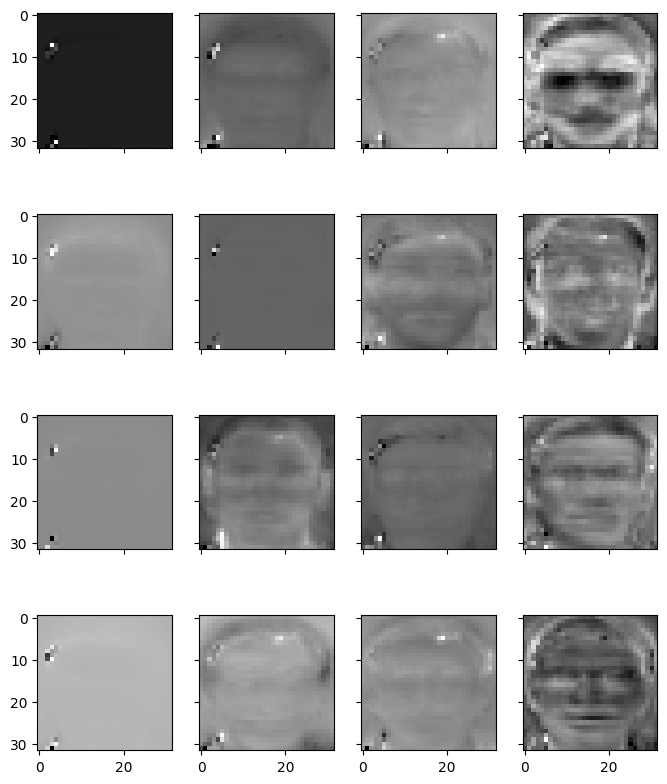

整体均值脸形状: (1024, 1)
DLPP权重矩阵形状: (70, 120)


In [10]:
dataset = "ORL"
data, labels, faceshape = read_images(dataset)
print("类别数量：", len(labels))
print("图像数据形状：", data.shape)
train_data, train_labels, test_data, test_labels = train_test_split(data, labels, train_test_split_ratio=0.3)
print("训练集形状：", train_data.shape)
d = 70
k = 100
t = 60000
lpp_method = 'knn'  # 'knn'或'epsilon'

"""
d = 70
k = 100
t = 60000
lpp_method = 'epsilon'  # 'knn'或'epsilon'
"""
dlpp_eigenfaces = DLPP(train_data, train_labels, d, lpp_method, k, t)
print("DLPP特征脸形状:", dlpp_eigenfaces.shape)
ShowEigenface(dlpp_eigenfaces, faceshape)

overall_mean = np.mean(train_data, axis=0).reshape(-1, 1)
print("整体均值脸形状:", overall_mean.shape)
dlpp_weight_matrix = np.dot(dlpp_eigenfaces.T, train_data.T- overall_mean)
print("DLPP权重矩阵形状:", dlpp_weight_matrix.shape)

In [11]:
# 识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, faceshape, overall_mean, train_labels, train_data, test_labels, test_data[i], dlpp_eigenfaces, dlpp_weight_matrix)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print(f"Recognition Rate: {rate}")

Recognition Rate: 0.8035714285714286


In [12]:
"""
# 调整参数循环测试并生成结果

# 定义参数范围
d = 30
k_range = range(3000, 9001, 500)
t_range = range(500000, 1450001, 50000)
lpp_method = 'knn'

# 检查 CSV 文件是否存在
csv_filename = 'outcome.csv'
if not os.path.exists(csv_filename):
    # 如果文件不存在，创建一个新的 DataFrame
    df = pd.DataFrame(columns=['k', 't', 'rate'])
else:
    # 如果文件存在，读取已有的结果
    df = pd.read_csv(csv_filename)

# 遍历参数
iteration = 1
for k in k_range:
    for t in t_range:
        # 检查结果是否已经存在
        if ((df['k'] == k) & (df['t'] == t)).any():
            continue  # 如果结果已经存在，跳过这个参数组合
        
        # 输出当前参数信息
        print(f"Iteration {iteration}: k={k}, t={t}")
        
        # 计算 DLPP
        dlpp_weight_matrix, overall_mean = DLPP(train_data, train_labels, d, lpp_method, k, t)
        dlpp_eigenfaces = np.dot(train_data.T, dlpp_weight_matrix)
        
        # 识别率统计
        wrong_times = 0
        right_times = 0
        for i in range(test_data.shape[0]):
            flag = test_image(i, faceshape, overall_mean, train_labels, train_data, test_data, dlpp_eigenfaces, dlpp_weight_matrix)
            if flag:
                right_times += 1
            else:
                wrong_times += 1
        rate = right_times / (right_times + wrong_times)
        print(f"Recognition Rate: {rate}")
        
        # 添加结果到 DataFrame
        df = pd.concat([df, pd.DataFrame({'k': [k], 't': [t], 'rate': [rate]})], ignore_index=True)

        # 保存结果到 CSV 文件
        df.to_csv(csv_filename, index=False)
        
        # 增加迭代计数
        iteration += 1
"""

'\n# 调整参数循环测试并生成结果\n\n# 定义参数范围\nd = 30\nk_range = range(3000, 9001, 500)\nt_range = range(500000, 1450001, 50000)\nlpp_method = \'knn\'\n\n# 检查 CSV 文件是否存在\ncsv_filename = \'outcome.csv\'\nif not os.path.exists(csv_filename):\n    # 如果文件不存在，创建一个新的 DataFrame\n    df = pd.DataFrame(columns=[\'k\', \'t\', \'rate\'])\nelse:\n    # 如果文件存在，读取已有的结果\n    df = pd.read_csv(csv_filename)\n\n# 遍历参数\niteration = 1\nfor k in k_range:\n    for t in t_range:\n        # 检查结果是否已经存在\n        if ((df[\'k\'] == k) & (df[\'t\'] == t)).any():\n            continue  # 如果结果已经存在，跳过这个参数组合\n        \n        # 输出当前参数信息\n        print(f"Iteration {iteration}: k={k}, t={t}")\n        \n        # 计算 DLPP\n        dlpp_weight_matrix, overall_mean = DLPP(train_data, train_labels, d, lpp_method, k, t)\n        dlpp_eigenfaces = np.dot(train_data.T, dlpp_weight_matrix)\n        \n        # 识别率统计\n        wrong_times = 0\n        right_times = 0\n        for i in range(test_data.shape[0]):\n            flag = test_image(i